In [1]:
pip install wordsegment transformers wordcloud scipy

Note: you may need to restart the kernel to use updated packages.


In [3]:
import pandas as pd
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import scipy.stats as stats
import spacy
from tqdm import tqdm
from nltk.sentiment import SentimentIntensityAnalyzer
import nltk
from nltk.tokenize import word_tokenize
from scipy.stats import shapiro, ttest_1samp, mannwhitneyu, wilcoxon
from collections import Counter
from scipy.stats import linregress 

nltk.download('punkt') 
nlp = spacy.load("en_core_web_sm")

pd.set_option('display.max_columns', None)

[nltk_data] Downloading package punkt to /Users/m.m/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [62]:
df = pd.read_json("/Users/m.m/Downloads/final_df_normalized_shrt.json")

In [50]:
df.head()

,internal_id,id,from,value,basic_clean_text,fully_clean_text,word_count,stopword_count,Hedges,Swearing,Reassurance,Please,Gratitude,Apology,Affirmation,norm_Hedges,norm_Swearing,norm_Reassurance,norm_Please,norm_Gratitude,norm_Apology,norm_Affirmation
0,0,QWJhYvA,human,Summarize the main ideas of Jeff Walker's Prod...,summarize the main ideas of jeff walkers produ...,summarize main idea jeff walker product launch...,29,11,0,0,0,0,0,0,0,0.0000,0.0,0.0,0.0,0.0,0.0,0.0
1,1,QWJhYvA,gpt,Here are the main ideas of Jeff Walker's Produ...,here are the main ideas of jeff walkers produc...,main idea jeff walker product launch formula c...,202,74,0,0,0,0,0,0,0,0.0000,0.0,0.0,0.0,0.0,0.0,0.0
2,2,QWJhYvA,human,Summarize the main ideas of Brendon Burchard's...,summarize the main ideas of brendon burchards ...,summarize main idea brendon burchards expert a...,28,11,0,0,0,0,0,0,0,0.0000,0.0,0.0,0.0,0.0,0.0,0.0
3,3,QWJhYvA,gpt,Here are the main ideas of Brendon Burchard's ...,here are the main ideas of brendon burchards e...,main idea brendon burchards expert academy can...,260,102,1,0,0,0,0,0,0,0.0038,0.0,0.0,0.0,0.0,0.0,0.0
4,4,QWJhYvA,human,What are the mental triggers in Jeff Walker's ...,what are the mental triggers in jeff walkers p...,mental trigger jeff walker product launch form...,14,5,0,0,0,0,0,0,0,0.0000,0.0,0.0,0.0,0.0,0.0,0.0


In [51]:
print(df.columns.tolist())

['internal_id', 'id', 'from', 'value', 'basic_clean_text', 'fully_clean_text', 'word_count', 'stopword_count', 'Hedges', 'Swearing', 'Reassurance', 'Please', 'Gratitude', 'Apology', 'Affirmation', 'norm_Hedges', 'norm_Swearing', 'norm_Reassurance', 'norm_Please', 'norm_Gratitude', 'norm_Apology', 'norm_Affirmation']


### General analysis

In [52]:
df.shape

(602996, 22)

In [53]:
df['id'].nunique()

48252

In [54]:
df['from'].value_counts()

human    301498
gpt      301498
Name: from, dtype: int64

Message count

In [55]:
messages_per_chat = df.groupby('id').size()

average_messages_per_chat = messages_per_chat.mean()
std_dev_messages_per_chat = messages_per_chat.std()
quantiles_messages_per_chat = messages_per_chat.quantile([0.25, 0.5, 0.75])

print(round(average_messages_per_chat,4))
print(round(std_dev_messages_per_chat,4))
print(quantiles_messages_per_chat)

12.4968
22.5531
0.25     2.0
0.50     6.0
0.75    14.0
dtype: float64


Message length

In [100]:
df['text_length'] = df['fully_clean_text'].str.len()

average_length_per_chat = df.groupby(['id', 'from'])['text_length'].mean()
overall_average_length = df.groupby('from')['text_length'].mean()

std_dev_length = df.groupby('from')['text_length'].std()
quantiles_length = df.groupby('from')['text_length'].quantile([0.25, 0.5, 0.75])

print(f"Mean length of messages by gpt/human: {round(overall_average_length,4)}")
print(f"St dev of length of messages by gpt/human: {round(std_dev_length,4)}")
print(f"Quatiles of message legth by gpt/human: {quantiles_length}")

Mean length of messages by gpt/human: from
gpt      889.8980
human    225.2291
Name: text_length, dtype: float64
St dev of length of messages by gpt/human: from
gpt       588.6176
human    1359.8856
Name: text_length, dtype: float64
Quatiles of message legth by gpt/human: from       
gpt    0.25     444.0
       0.50     812.0
       0.75    1213.0
human  0.25      29.0
       0.50      54.0
       0.75     117.0
Name: text_length, dtype: float64


Word cloud

In [57]:
def generate_word_cloud(data, column, title):
    """Generates and displays a word cloud."""
    text = " ".join(data[column].dropna())
    wordcloud = WordCloud(width=800, height=400, background_color="white", max_words=500).generate(text)
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    plt.title(title, fontsize=14)
    plt.show()

In [58]:
human_data = df[df['from'] == 'human']
gpt_data = df[df['from'] == 'gpt']

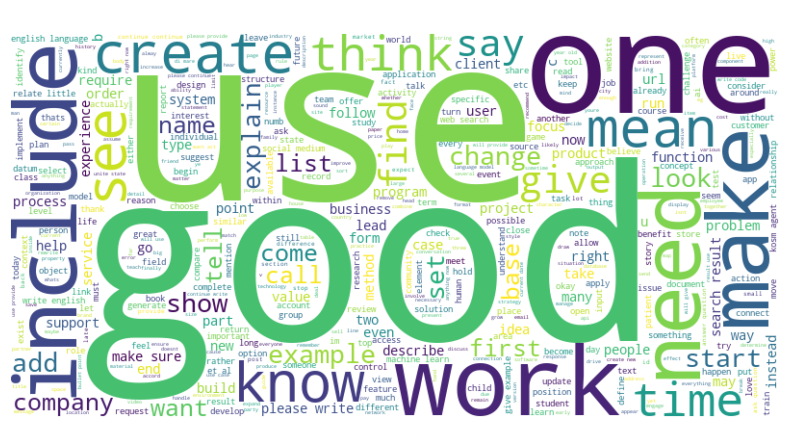

In [59]:
generate_word_cloud(human_data, 'fully_clean_text', f" ")

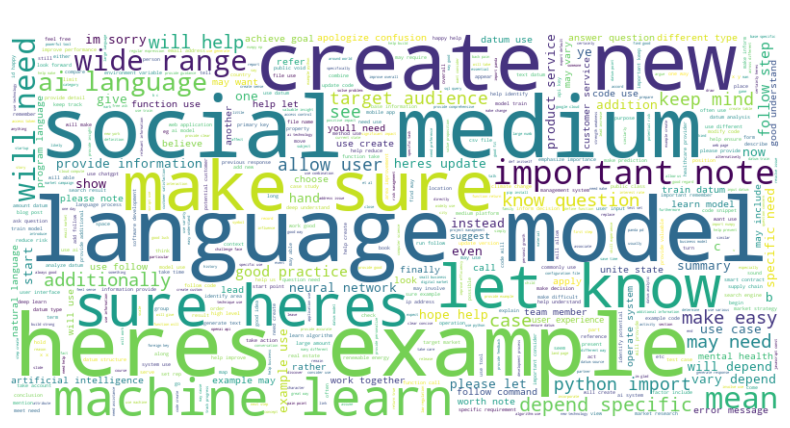

In [60]:
generate_word_cloud(gpt_data, 'fully_clean_text', f" ")

Stop Words ratio

In [63]:
average_stopword_per_chat = df.groupby('from')['norm_stopword_count'].mean()

std_dev_stopword = df.groupby('from')['norm_stopword_count'].std()
quantiles_stopword = df.groupby('from')['norm_stopword_count'].quantile([0.25, 0.5, 0.75])

print(round(average_stopword_per_chat,4))
print(round(std_dev_stopword,4))
print(quantiles_stopword)

from
gpt      0.3995
human    0.4116
Name: norm_stopword_count, dtype: float64
from
gpt      0.0970
human    0.1569
Name: norm_stopword_count, dtype: float64
from       
gpt    0.25    0.3529
       0.50    0.4118
       0.75    0.4626
human  0.25    0.3333
       0.50    0.4286
       0.75    0.5000
Name: norm_stopword_count, dtype: float64


Number of unique words

In [64]:
df['tokenized_words'] = df['fully_clean_text'].apply(lambda x: word_tokenize(x.lower()) if isinstance(x, str) else [])

In [65]:
df['unique_words'] = df['tokenized_words'].apply(lambda x: len(set(x)) if isinstance(x, list) else 0)

In [66]:
vocab_summary = {}

# Iterate over each group
for group_name, group_data in df.groupby('from'):
    # Flatten and calculate total unique vocabulary size
    total_vocab_size = len(set(word for words in group_data['tokenized_words'] if isinstance(words, list) for word in words))
    
    # Descriptive statistics for unique_words
    stats = group_data['unique_words'].describe(percentiles=[0.25, 0.5, 0.75])
    
    # Store in vocab_summary
    vocab_summary[group_name] = {
        'vocab_size': total_vocab_size,  # Correct vocabulary size
        'mean': stats['mean'],
        'std': stats['std'],
        '25%': stats['25%'],
        '50%': stats['50%'],
        '75%': stats['75%']
    }

# Convert the summary dictionary into a dataframe
summary = pd.DataFrame.from_dict(vocab_summary, orient='index')
print(summary)

       vocab_size       mean        std   25%   50%   75%
gpt        565710  69.024886  37.391161  43.0  66.0  91.0
human      311374  20.069602  54.316072   4.0   8.0  16.0


Statistical analysis of unique words ratio

In [70]:
df['text_length'] = df['fully_clean_text'].apply(lambda x: len(str(x)))

df.head()

,internal_id,id,from,value,basic_clean_text,fully_clean_text,word_count,stopword_count,Hedges,Swearing,Reassurance,Please,Gratitude,Apology,Affirmation,norm_Hedges,norm_Swearing,norm_Reassurance,norm_Please,norm_Gratitude,norm_Apology,norm_Affirmation,norm_stopword_count,tokenized_words,unique_words,text_length
0,0,QWJhYvA,human,Summarize the main ideas of Jeff Walker's Prod...,summarize the main ideas of jeff walkers produ...,summarize main idea jeff walker product launch...,29,11,0,0,0,0,0,0,0,0.0000,0.0,0.0,0.0,0.0,0.0,0.0,0.3793,"[summarize, main, idea, jeff, walker, product,...",18,129
1,1,QWJhYvA,gpt,Here are the main ideas of Jeff Walker's Produ...,here are the main ideas of jeff walkers produc...,main idea jeff walker product launch formula c...,202,74,0,0,0,0,0,0,0,0.0000,0.0,0.0,0.0,0.0,0.0,0.0,0.3663,"[main, idea, jeff, walker, product, launch, fo...",88,933
2,2,QWJhYvA,human,Summarize the main ideas of Brendon Burchard's...,summarize the main ideas of brendon burchards ...,summarize main idea brendon burchards expert a...,28,11,0,0,0,0,0,0,0,0.0000,0.0,0.0,0.0,0.0,0.0,0.0,0.3929,"[summarize, main, idea, brendon, burchards, ex...",17,127
3,3,QWJhYvA,gpt,Here are the main ideas of Brendon Burchard's ...,here are the main ideas of brendon burchards e...,main idea brendon burchards expert academy can...,260,102,1,0,0,0,0,0,0,0.0038,0.0,0.0,0.0,0.0,0.0,0.0,0.3923,"[main, idea, brendon, burchards, expert, acade...",103,1150
4,4,QWJhYvA,human,What are the mental triggers in Jeff Walker's ...,what are the mental triggers in jeff walkers p...,mental trigger jeff walker product launch form...,14,5,0,0,0,0,0,0,0,0.0000,0.0,0.0,0.0,0.0,0.0,0.0,0.3571,"[mental, trigger, jeff, walker, product, launc...",8,61


In [101]:
# Group by 'id' (chat ID) and 'from' (agent)
chat_level_stats = df.groupby(['id', 'from']).agg(
    total_text_length=('text_length', 'sum')  # Sum of text lengths for each chat
).reset_index()

# Calculate total unique words based on tokenized_words
total_unique_words = (
    df.groupby(['id', 'from'])['tokenized_words']
    .apply(lambda group: len(set(word for words in group if isinstance(words, list) for word in words)))
    .reset_index(name='total_unique_words')  # Rename the column for clarity
)

# Merge the total unique words back into the chat-level stats
chat_level_stats = chat_level_stats.merge(total_unique_words, on=['id', 'from'])

# Calculate vocab_ratio at the chat level
chat_level_stats['vocab_ratio'] = chat_level_stats['total_unique_words'] / chat_level_stats['total_text_length']

In [102]:
chat_level_stats

,id,from,total_text_length,total_unique_words,vocab_ratio
0,0068g9i,gpt,6687,277,0.041424
1,0068g9i,human,2443,171,0.069996
2,008UbdD,gpt,1339,106,0.079164
3,008UbdD,human,132,11,0.083333
4,00B9jFM,gpt,805,77,0.095652
...,...,...,...,...,...
96499,zzdsWDm,human,635,26,0.040945
96500,zzh5WAE,gpt,5298,216,0.040770
96501,zzh5WAE,human,361,34,0.094183
96502,zzs8XiG,gpt,4115,321,0.078007


In [103]:
chat_level_stats[chat_level_stats['vocab_ratio'].isnull()]

,id,from,total_text_length,total_unique_words,vocab_ratio
441,0GHbxYk,human,0,0,NaN
2915,1oKv8JN,human,0,0,NaN
2995,1r1h9U6,human,0,0,NaN
3473,28Lunbp,human,0,0,NaN
6215,3piNCe4,human,0,0,NaN
6561,41PtAKK,human,0,0,NaN
13473,89JtJjf,human,0,0,NaN
13752,8KqpSOb,gpt,0,0,NaN
16387,9ue6qMi,human,0,0,NaN
18079,AuvbVMI,human,0,0,NaN


In [104]:
df[df['id'] == 'vzBzoKr']

,internal_id,id,from,value,basic_clean_text,fully_clean_text,word_count,stopword_count,Hedges,Swearing,Reassurance,Please,Gratitude,Apology,Affirmation,norm_Hedges,norm_Swearing,norm_Reassurance,norm_Please,norm_Gratitude,norm_Apology,norm_Affirmation,norm_stopword_count,tokenized_words,unique_words,text_length,time_step
65428,65428,vzBzoKr,human,Links to all Leetcode Posts by theabbie,links to all leetcode posts by theabbie,link leetcode post theabbie,7,3,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.4286,"[link, leetcode, post, theabbie]",4,27,1
65429,65429,vzBzoKr,gpt,[https://leetcode.com/discuss/topic/3174056/bi...,...,,1,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0000,[],0,0,2


In [105]:
chat_level_stats['vocab_ratio'].isna().sum()

44

In [106]:
chat_level_stats_cleaned = chat_level_stats.dropna(subset=['vocab_ratio'])

In [107]:
agent_stats = chat_level_stats_cleaned.groupby('from')['vocab_ratio'].agg(['mean', 'std', lambda x: x.quantile(0.25), 'median', lambda x: x.quantile(0.75)])
agent_stats.columns = ['mean', 'std', '25%', '50%', '75%']
agent_stats

,mean,std,25%,50%,75%
from,,,,,
gpt,0.064815,0.031733,0.040887,0.059798,0.083050
human,0.110201,0.040166,0.083547,0.108808,0.134694


In [78]:
# Shapiro-Wilk Test for Human
human_shapiro_stat, human_shapiro_p = shapiro(chat_level_stats_cleaned[chat_level_stats_cleaned['from'] == 'human']['vocab_ratio'].dropna())
print("Human Shapiro-Wilk Test: Statistic=", human_shapiro_stat, ", p=", human_shapiro_p)

# Shapiro-Wilk Test for GPT
gpt_shapiro_stat, gpt_shapiro_p = shapiro(chat_level_stats_cleaned[chat_level_stats_cleaned['from'] == 'gpt']['vocab_ratio'].dropna())
print("GPT Shapiro-Wilk Test: Statistic=", gpt_shapiro_stat, ", p=", gpt_shapiro_p)

Human Shapiro-Wilk Test: Statistic= 0.9693136811256409 , p= 0.0
GPT Shapiro-Wilk Test: Statistic= 0.9380301833152771 , p= 0.0


/Users/m.m/anaconda3/lib/python3.11/site-packages/scipy/stats/_morestats.py:1816: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


In [108]:
human_vocab_ratio = chat_level_stats_cleaned[chat_level_stats_cleaned['from'] == 'human']['vocab_ratio']
gpt_vocab_ratio = chat_level_stats_cleaned[chat_level_stats_cleaned['from'] == 'gpt']['vocab_ratio']

In [109]:
u_stat, u_p = mannwhitneyu(human_vocab_ratio, gpt_vocab_ratio, alternative='two-sided')
print(f"Mann-Whitney U Test: Statistic={u_stat}, p={u_p}")

Mann-Whitney U Test: Statistic=1915156372.0, p=0.0


Gpt/human ratio

In [110]:
pivoted = chat_level_stats.pivot(index='id', columns='from', values='vocab_ratio').reset_index()
pivoted['vocab_ratio_gpt/human'] = pivoted['gpt'] / pivoted['human']

pivoted = pivoted.dropna(subset=['vocab_ratio_gpt/human'])

In [111]:
stat, p_normality = shapiro(pivoted['vocab_ratio_gpt/human'])
print(f"Shapiro-Wilk Test for Normality: Statistic={stat}, p={p_normality}")

Shapiro-Wilk Test for Normality: Statistic=0.43185955286026, p=0.0


/Users/m.m/anaconda3/lib/python3.11/site-packages/scipy/stats/_morestats.py:1816: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


In [112]:
hypothesized_mean = 1 

stat, p_wilcoxon = wilcoxon(pivoted['vocab_ratio_gpt/human'] - hypothesized_mean)
print(f"Wilcoxon Signed-Rank Test: Statistic={stat}, p-value={p_wilcoxon}")

Wilcoxon Signed-Rank Test: Statistic=68625678.5, p-value=0.0


### CAT

In [113]:
sia = SentimentIntensityAnalyzer()

In [114]:
file_path = '/Users/m.m/Downloads/LIWC2007_English100131.dic'

In [115]:
def extract_functional_words(file_path):
    """
    Extract words associated with the 'funct' category from a LIWC .dic file.
    
    Args:
        file_path (str): Path to the LIWC .dic file.
    
    Returns:
        list: Sorted list of functional words.
    """
    functional_words = set()
    is_parsing_words = False

    with open(file_path, 'r', encoding='utf-8') as f:
        for line in f:
            line = line.strip()
            
            # Start parsing words after categories are defined
            if not is_parsing_words:
                if not line.startswith('%'):
                    is_parsing_words = True
                continue

            # Parse word lines
            if is_parsing_words and line:
                parts = line.split()
                word = parts[0]
                categories = parts[1:]
                if '1' in categories or 'funct' in categories:  # Check for 'funct' category (ID or name)
                    functional_words.add(word)

    return sorted(functional_words)

In [116]:
function_words = extract_functional_words(file_path)

In [117]:
print(function_words)

['a', 'about', 'above', 'absolutely', 'across', 'actually', 'after', 'again', 'against', 'ahead', "ain't", 'aint', 'all', 'allot', 'along', 'alot', 'also', 'although', 'am', 'among*', 'an', 'and', 'another', 'any', 'anybod*', 'anymore', 'anyone*', 'anything', 'anyway*', 'anywhere', 'apparently', 'are', "aren't", 'arent', 'around', 'as', 'at', 'atho', 'atop', 'away', 'back', 'basically', 'be', 'became', 'because', 'become', 'becomes', 'becoming', 'been', 'before', 'behind', 'being', 'below', 'beneath', 'beside', 'besides', 'best', 'between', 'beyond', 'billion*', 'both', 'bunch', 'but', 'by', 'can', "can't", 'cannot', 'cant', 'cetera', 'clearly', 'completely', 'constantly', 'could', "could've", "couldn't", 'couldnt', 'couldve', 'couple', 'cuz', 'definitely', 'despite', 'did', "didn't", 'didnt', 'difference*', 'do', 'does', "doesn't", 'doesnt', 'doing', "don't", 'done', 'dont', 'doubl*', 'down', 'dozen*', 'during', 'each', 'eight*', 'either', 'eleven', 'else', 'enough', 'entire*', 'equal

In [118]:
# politeness_columns = ['Hedges', 'Swearing', 'Reassurance', 'Please', 'Gratitude', 'Apology', 'Affirmation']
politeness_columns = ['Hedges', 'Please', 'Gratitude', 'Apology', 'Affirmation']

In [119]:
def calculate_word_overlap(text1, text2):
    words1 = set(text1.lower().split())
    words2 = set(text2.lower().split())
    return len(words1 & words2) / len(words1 | words2) if words1 | words2 else 0

In [120]:
def count_function_words(text, function_words):
    tokens = text.lower().split()
    counts = Counter(token for token in tokens if token in function_words)
    return counts

In [121]:
def calculate_lsm(text1, text2, function_words):
    counts1 = count_function_words(text1, function_words)
    counts2 = count_function_words(text2, function_words)
    lsm_scores = []
    for word in function_words:
        A = counts1.get(word, 0)
        B = counts2.get(word, 0)
        lsm = 1 - abs(A - B) / (A + B + 0.0001)  # Avoid division by zero
        lsm_scores.append(lsm)
    return sum(lsm_scores) / len(lsm_scores) if lsm_scores else 0

In [122]:
def calculate_politeness_alignment(turn1, turn2, politeness_columns):
    score1 = turn1[politeness_columns].sum()
    score2 = turn2[politeness_columns].sum()
    return 1 - abs(score1 - score2) / (score1 + score2 + 0.0001)  # Avoid division by zero

In [123]:
def calculate_sentiment_alignment(text1, text2):
    sentiment1 = sia.polarity_scores(text1)['compound']
    sentiment2 = sia.polarity_scores(text2)['compound']
    return 1 - abs(sentiment1 - sentiment2)

In [125]:
# Initialize new columns
df['word_overlap'] = 0.0
df['lsm'] = 0.0
df['politeness'] = 0.0
df['sentiment'] = 0.0

# Iterate over rows with a progress bar
for i in tqdm(range(len(df) - 1), desc="Calculating Metrics"):
    # Ensure transitions are within the same chat
    if df.iloc[i]['id'] == df.iloc[i + 1]['id']:  # Same chat ID
        text1 = df.iloc[i]['fully_clean_text']  # Replace with actual text column
        text2 = df.iloc[i + 1]['fully_clean_text']
        turn1 = df.iloc[i]  # Full row for turn 1
        turn2 = df.iloc[i + 1]  # Full row for turn 2

        # Human → GPT or GPT → Human transitions
        if (df.iloc[i]['from'] == 'human' and df.iloc[i + 1]['from'] == 'gpt') or \
           (df.iloc[i]['from'] == 'gpt' and df.iloc[i + 1]['from'] == 'human'):
            # Calculate metrics
            df.loc[i, 'word_overlap'] = calculate_word_overlap(text1, text2)
            df.loc[i, 'lsm'] = calculate_lsm(text1, text2, function_words)
            df.loc[i, 'politeness'] = calculate_politeness_alignment(turn1, turn2, politeness_columns)
            df.loc[i, 'sentiment'] = calculate_sentiment_alignment(text1, text2)


Calculating Metrics: 100%|█████████████| 602995/602995 [26:10<00:00, 383.98it/s]


In [126]:
df['overall_accommodation'] = df[['word_overlap', 'lsm', 'politeness', 'sentiment']].mean(axis=1)

In [127]:
df['turn'] = df.groupby(['id', 'from']).cumcount() + 1

In [128]:
df.head()

,internal_id,id,from,value,basic_clean_text,fully_clean_text,word_count,stopword_count,Hedges,Swearing,Reassurance,Please,Gratitude,Apology,Affirmation,norm_Hedges,norm_Swearing,norm_Reassurance,norm_Please,norm_Gratitude,norm_Apology,norm_Affirmation,norm_stopword_count,tokenized_words,unique_words,text_length,time_step,word_overlap,lsm,politeness,sentiment,overall_accommodation,turn
0,0,QWJhYvA,human,Summarize the main ideas of Jeff Walker's Prod...,summarize the main ideas of jeff walkers produ...,summarize main idea jeff walker product launch...,29,11,0,0,0,0,0,0,0,0.0000,0.0,0.0,0.0,0.0,0.0,0.0,0.3793,"[summarize, main, idea, jeff, walker, product,...",18,129,1,0.115789,0.997859,1.0000,0.3867,0.625087,1
1,1,QWJhYvA,gpt,Here are the main ideas of Jeff Walker's Produ...,here are the main ideas of jeff walkers produc...,main idea jeff walker product launch formula c...,202,74,0,0,0,0,0,0,0,0.0000,0.0,0.0,0.0,0.0,0.0,0.0,0.3663,"[main, idea, jeff, walker, product, launch, fo...",88,933,2,0.060606,0.997859,1.0000,0.3867,0.611291,1
2,2,QWJhYvA,human,Summarize the main ideas of Brendon Burchard's...,summarize the main ideas of brendon burchards ...,summarize main idea brendon burchards expert a...,28,11,0,0,0,0,0,0,0,0.0000,0.0,0.0,0.0,0.0,0.0,0.0,0.3929,"[summarize, main, idea, brendon, burchards, ex...",17,127,3,0.100917,0.991435,0.0001,0.3929,0.371338,2
3,3,QWJhYvA,gpt,Here are the main ideas of Brendon Burchard's ...,here are the main ideas of brendon burchards e...,main idea brendon burchards expert academy can...,260,102,1,0,0,0,0,0,0,0.0038,0.0,0.0,0.0,0.0,0.0,0.0,0.3923,"[main, idea, brendon, burchards, expert, acade...",103,1150,4,0.018349,0.989294,0.0001,0.0111,0.254711,2
4,4,QWJhYvA,human,What are the mental triggers in Jeff Walker's ...,what are the mental triggers in jeff walkers p...,mental trigger jeff walker product launch form...,14,5,0,0,0,0,0,0,0,0.0000,0.0,0.0,0.0,0.0,0.0,0.0,0.3571,"[mental, trigger, jeff, walker, product, launc...",8,61,5,0.085106,0.993577,1.0000,0.0067,0.521346,3


In [129]:
# df.to_csv('/Users/m.m/Downloads/CAT_upd.csv')

In [130]:
human = df[df['from'] == 'human'].groupby('id').filter(lambda x: len(x) > 1)
gpt = df[df['from'] == 'gpt'].groupby('id').filter(lambda x: len(x) > 1)

In [131]:
human.head()

,internal_id,id,from,value,basic_clean_text,fully_clean_text,word_count,stopword_count,Hedges,Swearing,Reassurance,Please,Gratitude,Apology,Affirmation,norm_Hedges,norm_Swearing,norm_Reassurance,norm_Please,norm_Gratitude,norm_Apology,norm_Affirmation,norm_stopword_count,tokenized_words,unique_words,text_length,time_step,word_overlap,lsm,politeness,sentiment,overall_accommodation,turn
0,0,QWJhYvA,human,Summarize the main ideas of Jeff Walker's Prod...,summarize the main ideas of jeff walkers produ...,summarize main idea jeff walker product launch...,29,11,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.3793,"[summarize, main, idea, jeff, walker, product,...",18,129,1,0.115789,0.997859,1.000000,0.3867,0.625087,1
2,2,QWJhYvA,human,Summarize the main ideas of Brendon Burchard's...,summarize the main ideas of brendon burchards ...,summarize main idea brendon burchards expert a...,28,11,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.3929,"[summarize, main, idea, brendon, burchards, ex...",17,127,3,0.100917,0.991435,0.000100,0.3929,0.371338,2
4,4,QWJhYvA,human,What are the mental triggers in Jeff Walker's ...,what are the mental triggers in jeff walkers p...,mental trigger jeff walker product launch form...,14,5,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.3571,"[mental, trigger, jeff, walker, product, launc...",8,61,5,0.085106,0.993577,1.000000,0.0067,0.521346,3
6,6,QWJhYvA,human,Write a summary of why scarcity and urgency ar...,write a summary of why scarcity and urgency ar...,write summary scarcity urgency strong mental t...,31,14,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.4516,"[write, summary, scarcity, urgency, strong, me...",17,110,7,0.126437,0.982871,0.000025,0.7406,0.462483,4
8,8,QWJhYvA,human,Summarize Russell Brunson's Perfect Webinar Sc...,summarize russell brunsons perfect webinar script,summarize russell brunsons perfect webinar script,6,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0000,"[summarize, russell, brunsons, perfect, webina...",6,49,9,0.056180,0.993577,0.000050,0.5798,0.407402,5


In [132]:
human['turn'].mean()

14.468705172816971

In [133]:
def get_slope_scipy(x, y): 
    slope, intercept, r_value, p_value, std_err = linregress(x, y) 
    return slope

# df__ = df_[df_['id'] == 'QWJhYvA']

# get_slope_scipy(df__['turn'], df__['word_overlap'])

In [134]:
def get_slope_scipy(x, y):
    """
    Calculate the slope of the linear regression line using scipy.
    x: Independent variable (e.g., turn numbers)
    y: Dependent variable
    """
    if len(x) > 1 and len(y) > 1:  # Ensure sufficient data points
        slope, _, _, _, _ = linregress(x, y)
        return slope
    return None  # Return None if insufficient data

In [135]:
slopes = []

# Group by 'id' and calculate slopes for each metric
for chat_id, group in human.groupby('id'):
    slope_data = {'id': chat_id}  # Initialize a dictionary for this chat ID
    slope_data['word_overlap_slope'] = get_slope_scipy(group['turn'], group['word_overlap'])
    slope_data['lsm_slope'] = get_slope_scipy(group['turn'], group['lsm'])
    slope_data['politeness_slope'] = get_slope_scipy(group['turn'], group['politeness'])
    slope_data['sentiment_slope'] = get_slope_scipy(group['turn'], group['sentiment'])
    slope_data['overall_accommodation_slope'] = get_slope_scipy(group['turn'], group['overall_accommodation'])
    slopes.append(slope_data)
    
slope_human_df = pd.DataFrame(slopes)

In [136]:
slope_human_df.head()

,id,word_overlap_slope,lsm_slope,politeness_slope,sentiment_slope,overall_accommodation_slope
0,0068g9i,0.020078,0.003699,-0.009993,-0.000532,0.003313
1,00B9jFM,0.044372,-0.002141,-0.999900,0.422200,-0.133867
2,00KCKlp,-0.022215,0.000283,-0.000785,0.008238,-0.003620
3,00L9QeN,-0.009374,-0.003212,0.099995,-0.006530,0.020220
4,00LktrX,0.012369,0.000357,-0.059520,-0.021168,-0.016990


In [137]:
metrics = ['word_overlap_slope', 'lsm_slope', 'politeness_slope', 'sentiment_slope', 'overall_accommodation_slope']
hypothesized_mean = 0
results_human = []

for metric in metrics:
    # Extract data for the current metric
    data = slope_human_df[metric].dropna()  # Ensure no NaN values

    # Normality test
    stat, p_normality = shapiro(data)

    # Perform one-sample test
    t_stat, p_ttest = wilcoxon(data - hypothesized_mean)

    # Append results
    results_human.append({
        'metric': metric,
        'shapiro_stat': stat,
        'shapiro_p': p_normality,
        'w_stat': t_stat,
        'w_p': p_ttest
    })

results_human_df = pd.DataFrame(results_human)
results_human_df

/Users/m.m/anaconda3/lib/python3.11/site-packages/scipy/stats/_morestats.py:1816: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


,metric,shapiro_stat,shapiro_p,w_stat,w_p
0,word_overlap_slope,0.669392,0.0,157823992.0,0.000000e+00
1,lsm_slope,0.575628,0.0,264409614.0,7.854141e-03
2,politeness_slope,0.774682,0.0,204242877.5,3.909132e-11
3,sentiment_slope,0.829722,0.0,223526814.5,2.087941e-190
4,overall_accommodation_slope,0.853977,0.0,226045003.0,7.876307e-183


In [139]:
percentages_human = []

for metric in metrics:
    # Get the data for the current metric and drop NaN values
    data = slope_human_df[metric].dropna()
    
    # Calculate total number of valid entries
    total = len(data)
    
    # Calculate percentages
    positive_percentage = (data > 0).sum() / total * 100  # Percentage of positive values
    negative_percentage = (data < 0).sum() / total * 100  # Percentage of negative values
    
    # Store results
    percentages_human.append({
        'metric': metric,
        'positive_percentage': positive_percentage,
        'negative_percentage': negative_percentage
    })

# Convert results to a DataFrame
percentages_human_df = pd.DataFrame(percentages_human)
percentages_human_df

,metric,positive_percentage,negative_percentage
0,word_overlap_slope,34.185928,65.486460
1,lsm_slope,50.049593,48.534760
2,politeness_slope,42.162845,45.727510
3,sentiment_slope,43.100598,56.550750
4,overall_accommodation_slope,43.536413,56.424514


In [140]:
slopes = []

# Group by 'id' and calculate slopes for each metric
for chat_id, group in gpt.groupby('id'):
    slope_data = {'id': chat_id}  # Initialize a dictionary for this chat ID
    slope_data['word_overlap_slope'] = get_slope_scipy(group['turn'], group['word_overlap'])
    slope_data['lsm_slope'] = get_slope_scipy(group['turn'], group['lsm'])
    slope_data['politeness_slope'] = get_slope_scipy(group['turn'], group['politeness'])
    slope_data['sentiment_slope'] = get_slope_scipy(group['turn'], group['sentiment'])
    slope_data['overall_accommodation_slope'] = get_slope_scipy(group['turn'], group['overall_accommodation'])
    slopes.append(slope_data)
    
slope_gpt_df = pd.DataFrame(slopes)

In [141]:
slope_gpt_df.head()

,id,word_overlap_slope,lsm_slope,politeness_slope,sentiment_slope,overall_accommodation_slope
0,0068g9i,-0.002518,-0.065311,0.033330,0.032402,-0.000524
1,00B9jFM,-0.022222,-0.995718,-1.000000,-0.099900,-0.529460
2,00KCKlp,-0.004344,-0.017153,-0.021647,-0.015431,-0.014644
3,00L9QeN,-0.001809,-0.298608,-0.200005,-0.282900,-0.195831
4,00LktrX,0.005790,-0.105715,-0.023815,0.012225,-0.027879


In [144]:
slope_gpt_df.shape

(33271, 6)

In [142]:
results_gpt = []

for metric in metrics:
    # Extract data for the current metric
    data = slope_gpt_df[metric].dropna()  # Ensure no NaN values

    # Normality test
    stat, p_normality = shapiro(data)

    # Perform one-sample t-test
    t_stat, p_ttest = wilcoxon(data - hypothesized_mean)

    # Append results
    results_gpt.append({
        'metric': metric,
        'shapiro_stat': stat,
        'shapiro_p': p_normality,
        'w_stat': t_stat,
        'w_p': p_ttest
    })

results_gpt_df = pd.DataFrame(results_gpt)
results_gpt_df

/Users/m.m/anaconda3/lib/python3.11/site-packages/scipy/stats/_morestats.py:1816: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


,metric,shapiro_stat,shapiro_p,w_stat,w_p
0,word_overlap_slope,0.450347,0.0,38597965.0,0.0
1,lsm_slope,0.797705,0.0,0.0,0.0
2,politeness_slope,0.642376,0.0,84857308.0,0.0
3,sentiment_slope,0.788277,0.0,68187732.0,0.0
4,overall_accommodation_slope,0.823248,0.0,2840440.0,0.0


In [143]:
percentages_gpt = []

for metric in metrics:
    # Get the data for the current metric and drop NaN values
    data = slope_gpt_df[metric].dropna()
    
    # Calculate total number of valid entries
    total = len(data)
    
    # Calculate percentages
    positive_percentage = (data > 0).sum() / total * 100  # Percentage of positive values
    negative_percentage = (data < 0).sum() / total * 100  # Percentage of negative values
    
    # Store results
    percentages_gpt.append({
        'metric': metric,
        'positive_percentage': positive_percentage,
        'negative_percentage': negative_percentage
    })

# Convert results to a DataFrame
percentages_gpt_df = pd.DataFrame(percentages_gpt)
percentages_gpt_df

,metric,positive_percentage,negative_percentage
0,word_overlap_slope,15.674311,75.338884
1,lsm_slope,0.000000,100.000000
2,politeness_slope,16.335547,83.664453
3,sentiment_slope,19.082685,80.914310
4,overall_accommodation_slope,4.198852,95.801148


### Politeness

In [201]:
import json

df = pd.read_json("/Users/m.m/Downloads/politeness_results_normalized_shrt.json")

In [84]:
df.head()

,internal_id,id,from,value,basic_clean_text,fully_clean_text,word_count,stopword_count,Hedges,Swearing,Reassurance,Please,Gratitude,Apology,Affirmation,norm_Hedges,norm_Swearing,norm_Reassurance,norm_Please,norm_Gratitude,norm_Apology,norm_Affirmation,norm_stopword_count,tokenized_words,unique_words,text_length
0,0,QWJhYvA,human,Summarize the main ideas of Jeff Walker's Prod...,summarize the main ideas of jeff walkers produ...,summarize main idea jeff walker product launch...,29,11,0,0,0,0,0,0,0,0.0000,0.0,0.0,0.0,0.0,0.0,0.0,0.3793,"[summarize, main, idea, jeff, walker, product,...",18,129
1,1,QWJhYvA,gpt,Here are the main ideas of Jeff Walker's Produ...,here are the main ideas of jeff walkers produc...,main idea jeff walker product launch formula c...,202,74,0,0,0,0,0,0,0,0.0000,0.0,0.0,0.0,0.0,0.0,0.0,0.3663,"[main, idea, jeff, walker, product, launch, fo...",88,933
2,2,QWJhYvA,human,Summarize the main ideas of Brendon Burchard's...,summarize the main ideas of brendon burchards ...,summarize main idea brendon burchards expert a...,28,11,0,0,0,0,0,0,0,0.0000,0.0,0.0,0.0,0.0,0.0,0.0,0.3929,"[summarize, main, idea, brendon, burchards, ex...",17,127
3,3,QWJhYvA,gpt,Here are the main ideas of Brendon Burchard's ...,here are the main ideas of brendon burchards e...,main idea brendon burchards expert academy can...,260,102,1,0,0,0,0,0,0,0.0038,0.0,0.0,0.0,0.0,0.0,0.0,0.3923,"[main, idea, brendon, burchards, expert, acade...",103,1150
4,4,QWJhYvA,human,What are the mental triggers in Jeff Walker's ...,what are the mental triggers in jeff walkers p...,mental trigger jeff walker product launch form...,14,5,0,0,0,0,0,0,0,0.0000,0.0,0.0,0.0,0.0,0.0,0.0,0.3571,"[mental, trigger, jeff, walker, product, launc...",8,61


In [87]:
politeness_markers_normalized = ['norm_Hedges', 'norm_Swearing', 'norm_Reassurance', 'norm_Please', \
            'norm_Gratitude', 'norm_Apology', 'norm_Affirmation']

In [88]:
summary_stats = df.groupby('from')[politeness_markers_normalized].agg(['mean', 'std'])
summary_stats = summary_stats.round(4)
summary_stats

norm_Hedges         norm_Swearing         norm_Reassurance          \
             mean     std          mean     std             mean     std   
from                                                                       
gpt        0.0071  0.0110        0.0001  0.0017              0.0  0.0011   
human      0.0062  0.0216        0.0002  0.0056              0.0  0.0026   

      norm_Please         norm_Gratitude         norm_Apology          \
             mean     std           mean     std         mean     std   
from                                                                    
gpt        0.0012  0.0068         0.0005  0.0041       0.0009  0.0050   
human      0.0070  0.0399         0.0020  0.0302       0.0001  0.0041   

      norm_Affirmation          
                  mean     std  
from                            
gpt             0.0011  0.0176  
human           0.0025  0.0307

In [90]:
results = []

for marker in politeness_markers_normalized:
    # Split data into human and chatgpt groups
    human_data = df[df['from'] == 'human'][marker].dropna()
    chatgpt_data = df[df['from'] == 'gpt'][marker].dropna()

    # Initialize result placeholders
    human_shapiro_p = None
    chatgpt_shapiro_p = None
    mann_whitney_p = None
    mann_whitney_stat = None

    # Shapiro-Wilk test for normality (only if enough data points)
    if len(human_data) >= 3:
        human_shapiro_p = shapiro(human_data).pvalue
    if len(chatgpt_data) >= 3:
        chatgpt_shapiro_p = shapiro(chatgpt_data).pvalue

    # Mann-Whitney U test (non-parametric test for differences between groups)
    if len(human_data) >= 1 and len(chatgpt_data) >= 1:
        mann_whitney = mannwhitneyu(human_data, chatgpt_data, alternative='two-sided')
        mann_whitney_p = mann_whitney.pvalue
        mann_whitney_stat = mann_whitney.statistic
        
    # Store results
    results.append({
        'Marker': marker,
        'Human_Shapiro_p': human_shapiro_p,
        'ChatGPT_Shapiro_p': chatgpt_shapiro_p,
        'Mann_Whitney_p': mann_whitney_p,
        'Mann_Whitney_stat': mann_whitney_stat
    })

# Convert results to a DataFrame for better readability
results_df = pd.DataFrame(results)
results_df

/Users/m.m/anaconda3/lib/python3.11/site-packages/scipy/stats/_morestats.py:1816: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


,Marker,Human_Shapiro_p,ChatGPT_Shapiro_p,Mann_Whitney_p,Mann_Whitney_stat
0,norm_Hedges,0.0,0.0,0.000000e+00,3.057230e+10
1,norm_Swearing,0.0,0.0,5.043687e-04,4.539913e+10
2,norm_Reassurance,0.0,0.0,2.593902e-25,4.537427e+10
3,norm_Please,0.0,0.0,1.918566e-108,4.613382e+10
4,norm_Gratitude,0.0,0.0,0.000000e+00,4.427415e+10
5,norm_Apology,0.0,0.0,0.000000e+00,4.276291e+10
6,norm_Affirmation,0.0,0.0,0.000000e+00,4.376995e+10


In [94]:
df['time_step'].mean()

27.098929346131648

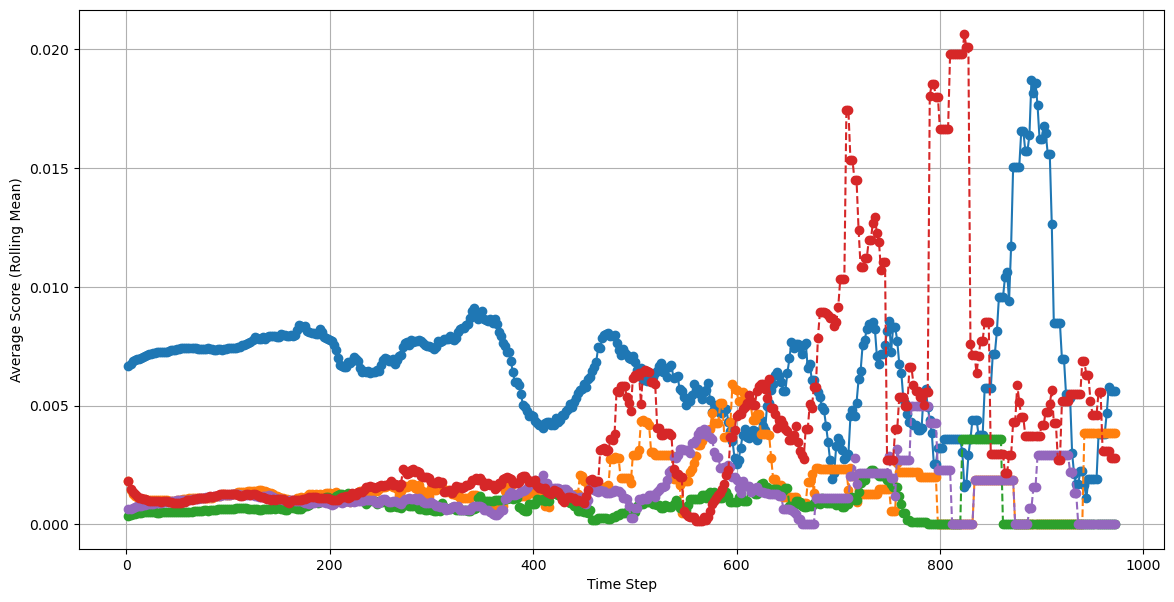

In [96]:
df['time_step'] = df.groupby('id').cumcount() + 1

gpt_scores = df[df['from'] == 'gpt'].groupby('time_step')[['norm_Hedges', \
                          'norm_Please', 'norm_Gratitude', 'norm_Apology', 'norm_Affirmation' ]].mean()
window_size = 20
gpt_scores_smoothed = gpt_scores.rolling(window=window_size, min_periods=1).mean()

plt.figure(figsize=(14, 7))

plt.rcParams['axes.prop_cycle'] = plt.cycler(color=['#1f77b4', '#ff7f0e', '#2ca02c', '#9467bd', '#d62728'])

# Plot smoothed GPT scores
plt.plot(gpt_scores_smoothed.index, gpt_scores_smoothed['norm_Hedges'], label='Hedges', linestyle='-', marker='o')
# plt.plot(gpt_scores_smoothed.index, gpt_scores_smoothed['norm_Swearing'], label='Swearing', linestyle='--', marker='o')
# plt.plot(gpt_scores_smoothed.index, gpt_scores_smoothed['norm_Reassurance'], label='Reassurance', linestyle='--', marker='o')
plt.plot(gpt_scores_smoothed.index, gpt_scores_smoothed['norm_Please'], label='Please', linestyle='--', marker='o')
plt.plot(gpt_scores_smoothed.index, gpt_scores_smoothed['norm_Gratitude'], label='Gratitude', linestyle='--', marker='o')
plt.plot(gpt_scores_smoothed.index, gpt_scores_smoothed['norm_Apology'], label='Apology', linestyle='--', marker='o')
plt.plot(gpt_scores_smoothed.index, gpt_scores_smoothed['norm_Affirmation'], label='Affirmation', linestyle='--', marker='o')

# Customize the plot
# plt.title('Smoothed Trend of GPT Politeness Features Over Time in Dialogue')
plt.xlabel('Time Step')
plt.ylabel('Average Score (Rolling Mean)')
# plt.legend()
plt.grid()
plt.show()

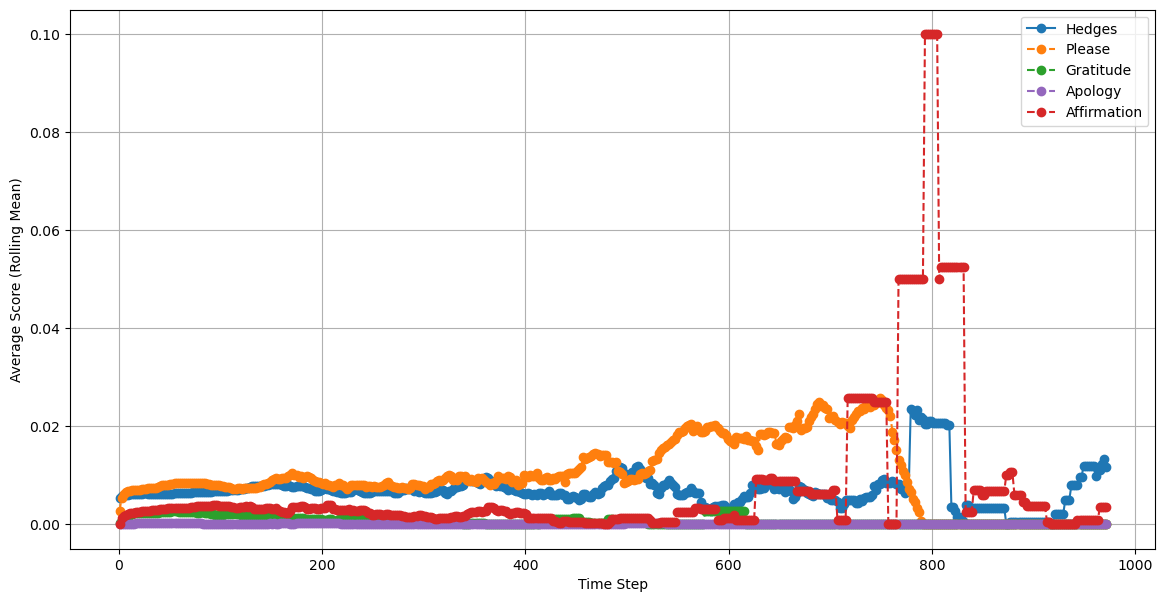

In [98]:
human_scores = df[df['from'] == 'human'].groupby('time_step')[['norm_Hedges', \
                          'norm_Please', 'norm_Gratitude', 'norm_Apology', 'norm_Affirmation' ]].mean()

human_scores_smoothed = human_scores.rolling(window=window_size, min_periods=1).mean()

plt.figure(figsize=(14, 7))

# Plot smoothed GPT scores
plt.plot(human_scores_smoothed.index, human_scores_smoothed['norm_Hedges'], label='Hedges', linestyle='-', marker='o')
# plt.plot(human_scores_smoothed.index, human_scores_smoothed['norm_Swearing'], label='Swearing', linestyle='--', marker='o')
# plt.plot(human_scores_smoothed.index, human_scores_smoothed['norm_Reassurance'], label='Reassurance', linestyle='--', marker='o')
plt.plot(human_scores_smoothed.index, human_scores_smoothed['norm_Please'], label='Please', linestyle='--', marker='o')
plt.plot(human_scores_smoothed.index, human_scores_smoothed['norm_Gratitude'], label='Gratitude', linestyle='--', marker='o')
plt.plot(human_scores_smoothed.index, human_scores_smoothed['norm_Apology'], label='Apology', linestyle='--', marker='o')
plt.plot(human_scores_smoothed.index, human_scores_smoothed['norm_Affirmation'], label='Affirmation', linestyle='--', marker='o')

# Customize the plot
# plt.title('Smoothed Trend of Human Politeness Features Over Time in Dialogue')
plt.xlabel('Time Step')
plt.ylabel('Average Score (Rolling Mean)')
plt.legend()
plt.grid()
plt.show()

In [194]:
prompts = pd.read_json("/Users/m.m/Downloads/prompts_politeness.json")

In [195]:
prompts.head()

,Type,Description,cleaned_text,politeness_score,word_count
0,neutral,1 Consider the following Project: \n • Projec...,consider the following project project name ...,"{'Hedges': 1, 'Impersonal.Pronoun': 5, 'Sweari...",310
1,polite,Hello! Could you help me with my project? Here...,hello could you help me with my project here i...,"{'Hedges': 1, 'Impersonal.Pronoun': 9, 'Sweari...",352
2,impolite,"Listen, I need you to help me with my project,...",listen i need you to help me with my project a...,"{'Hedges': 2, 'Impersonal.Pronoun': 12, 'Swear...",232


In [196]:
politeness_scores_df = pd.json_normalize(prompts['politeness_score'])

# Concatenating the extracted scores back with the original DataFrame
unparsed_prompts = pd.concat([prompts.drop(columns=['politeness_score']), politeness_scores_df], axis=1)

In [197]:
unparsed_prompts

,Type,Description,cleaned_text,word_count,Hedges,Impersonal.Pronoun,Swearing,Negation,Filler.Pause,Informal.Title,Formal.Title,Could.You,Can.You,By.The.Way,Let.Me.Know,Goodbye,For.Me,For.You,Reasoning,Contrast.Conjunction,Reassurance,Ask.Agency,Give.Agency,Hello,Please,First.Person.Plural,First.Person.Single,Second.Person,Third.Person,Positive.Emotion,Negative.Emotion,Questions,Gratitude,Apology,Truth.Intensifier,Affirmation,Conjunction.Start
0,neutral,1 Consider the following Project: \n • Projec...,consider the following project project name ...,310,1,5,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,6,0,10,1,0,0,0,0,0,0
1,polite,Hello! Could you help me with my project? Here...,hello could you help me with my project here i...,352,1,9,0,1,0,0,0,5,0,0,0,0,1,0,0,0,0,0,1,1,9,0,4,14,0,12,1,5,2,0,0,0,0
2,impolite,"Listen, I need you to help me with my project,...",listen i need you to help me with my project a...,232,2,12,0,7,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,8,7,2,1,6,2,0,0,1,0,0


In [ ]:
politeness_markers_normalized = ['norm_Hedges', 'norm_Swearing', 'norm_Reassurance', 'norm_Please', \
            'norm_Gratitude', 'norm_Apology', 'norm_Affirmation']